# Score prediction from dual-stream embeddings
We regress StackOverflow question scores using the provided question/title embeddings. The notebook walks through data loading, single-stream multilayer perceptrons, and the dual-stream fusion (DSF) attention models repurposed as regressors.

## Data sources
- `data/stackexchange_reduced_tags_embeddings.pkl`: precomputed 4,096-dim embeddings for titles and question bodies.
- `data/stackexchange_dataset.csv`: metadata with question scores and tag counts used as targets/auxiliary features.

In [1]:
from __future__ import annotations

import math
import sys
from pathlib import Path
from typing import Dict, List, Sequence, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from torch import nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset

PROJECT_ROOT = Path.cwd().resolve()
if PROJECT_ROOT.name == 'notebooks':
    PROJECT_ROOT = PROJECT_ROOT.parent
if not (PROJECT_ROOT / 'data').exists():
    raise FileNotFoundError('Unable to locate the data directory.')

NOTEBOOKS_DIR = PROJECT_ROOT / 'notebooks'
for path in {PROJECT_ROOT, NOTEBOOKS_DIR}:
    path_str = str(path.resolve())
    if path_str not in sys.path:
        sys.path.append(path_str)

DATA_PATH = PROJECT_ROOT / 'data' / 'stackexchange_reduced_tags_embeddings.pkl'
META_PATH = PROJECT_ROOT / 'data' / 'stackexchange_dataset.csv'

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Running on {device} — data source: {DATA_PATH.name}')

Running on cpu — data source: stackexchange_reduced_tags_embeddings.pkl


In [2]:
emb_df = pd.read_pickle(DATA_PATH)
meta_df = pd.read_csv(META_PATH, usecols=['question_id', 'question_score', 'num_tags'])

df = (
    emb_df.merge(meta_df, left_index=True, right_on='question_id', how='inner')
    .set_index('question_id')
    .rename(columns={'question_score': 'score'})
)

df['score'] = pd.to_numeric(df['score'], errors='coerce')
df['num_tags'] = df['num_tags'].fillna(0).astype(np.int16)
df = df.dropna(subset=['score'])
df['score'] = df['score'].astype(np.float32)

print(f'Samples joined: {len(df):,}')
df[['score', 'num_tags']].describe()

Samples joined: 100,000


,score,num_tags
count,100000.000000,100000.000000
mean,23.551849,3.110710
std,232.295502,1.215511
min,-20.000000,1.000000
25%,0.000000,2.000000
50%,1.000000,3.000000
75%,4.000000,4.000000
max,27487.000000,5.000000


In [3]:
def stack_embeddings(series: pd.Series) -> np.ndarray:
    return np.vstack(series.values).astype(np.float32)

title_embeddings = stack_embeddings(df['title_embedding'])
body_embeddings = stack_embeddings(df['question_text_embedding'])
scores = df['score'].to_numpy(dtype=np.float32)
num_tags = np.clip(df['num_tags'].to_numpy(dtype=np.float32), 0, 5)
question_ids = df.index.to_numpy()

print(f'title_embeddings: {title_embeddings.shape}, dtype={title_embeddings.dtype}')
print(f'body_embeddings: {body_embeddings.shape}')
print(f'Score range: {scores.min():.1f} → {scores.max():.1f}')

del df, emb_df, meta_df

title_embeddings: (100000, 4096), dtype=float32
body_embeddings: (100000, 4096)
Score range: -20.0 → 27487.0


In [4]:
indices = np.arange(len(scores))
train_idx, temp_idx = train_test_split(indices, test_size=0.20, random_state=SEED)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.50, random_state=SEED)

def describe_split(name: str, idx: np.ndarray):
    print(f"{name:>5}: {len(idx):6,d} samples ({len(idx) / len(scores):.1%})")

describe_split('Train', train_idx)
describe_split(' Val', val_idx)
describe_split('Test', test_idx)

Train: 80,000 samples (80.0%)
  Val: 10,000 samples (10.0%)
 Test: 10,000 samples (10.0%)


## Helper utilities

In [5]:
def regression_metrics(y_true: Sequence[float], y_pred: Sequence[float]) -> Dict[str, float]:
    y_true = np.asarray(y_true, dtype=np.float32)
    y_pred = np.asarray(y_pred, dtype=np.float32)
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

results_log: List[Dict[str, float]] = []
predictions: Dict[str, Tuple[np.ndarray, np.ndarray]] = {}

def log_result(name: str, features: str, val_metrics: Dict[str, float], test_metrics: Dict[str, float], notes: str = '', preds: np.ndarray | None = None, targets: np.ndarray | None = None):
    entry = {
        'model': name,
        'features': features,
        'val_RMSE': val_metrics['RMSE'],
        'val_MAE': val_metrics['MAE'],
        'val_R2': val_metrics['R2'],
        'test_RMSE': test_metrics['RMSE'],
        'test_MAE': test_metrics['MAE'],
        'test_R2': test_metrics['R2'],
        'notes': notes,
    }
    results_log.append(entry)
    if preds is not None and targets is not None:
        predictions[name] = (preds, targets)
    return entry

In [6]:
class SingleStreamDataset(Dataset):
    def __init__(self, embeddings: np.ndarray, target_scores: np.ndarray, indices: np.ndarray):
        self.embeddings = embeddings
        self.target_scores = target_scores
        self.indices = indices

    def __len__(self) -> int:
        return len(self.indices)

    def __getitem__(self, idx: int):
        i = self.indices[idx]
        emb = torch.from_numpy(self.embeddings[i])
        target = torch.tensor(self.target_scores[i], dtype=torch.float32)
        return emb, target


class DualStreamScoreDataset(Dataset):
    def __init__(
        self,
        title_embs: np.ndarray,
        body_embs: np.ndarray,
        tag_counts: np.ndarray,
        target_scores: np.ndarray,
        indices: np.ndarray,
    ):
        self.title_embs = title_embs
        self.body_embs = body_embs
        self.tag_counts = tag_counts
        self.target_scores = target_scores
        self.indices = indices

    def __len__(self) -> int:
        return len(self.indices)

    def __getitem__(self, idx: int):
        i = self.indices[idx]
        title = torch.from_numpy(self.title_embs[i])
        body = torch.from_numpy(self.body_embs[i])
        num_tags_norm = torch.tensor([self.tag_counts[i] / 5.0], dtype=torch.float32)
        target = torch.tensor(self.target_scores[i], dtype=torch.float32)
        return title, body, num_tags_norm, target


def make_single_stream_loaders(embeddings: np.ndarray, batch_size: int = 256):
    pin_memory = torch.cuda.is_available()
    train_loader = DataLoader(
        SingleStreamDataset(embeddings, scores, train_idx),
        batch_size=batch_size,
        shuffle=True,
        pin_memory=pin_memory,
    )
    val_loader = DataLoader(
        SingleStreamDataset(embeddings, scores, val_idx),
        batch_size=batch_size,
        shuffle=False,
        pin_memory=pin_memory,
    )
    test_loader = DataLoader(
        SingleStreamDataset(embeddings, scores, test_idx),
        batch_size=batch_size,
        shuffle=False,
        pin_memory=pin_memory,
    )
    return train_loader, val_loader, test_loader


def make_dual_stream_loaders(batch_size: int = 128):
    pin_memory = torch.cuda.is_available()
    train_loader = DataLoader(
        DualStreamScoreDataset(title_embeddings, body_embeddings, num_tags, scores, train_idx),
        batch_size=batch_size,
        shuffle=True,
        pin_memory=pin_memory,
    )
    val_loader = DataLoader(
        DualStreamScoreDataset(title_embeddings, body_embeddings, num_tags, scores, val_idx),
        batch_size=batch_size,
        shuffle=False,
        pin_memory=pin_memory,
    )
    test_loader = DataLoader(
        DualStreamScoreDataset(title_embeddings, body_embeddings, num_tags, scores, test_idx),
        batch_size=batch_size,
        shuffle=False,
        pin_memory=pin_memory,
    )
    return train_loader, val_loader, test_loader

In [7]:
from networks.dual_stream_fusion_network import DSF_MHSA_Classifier
from networks.dual_stream_fusion_crossatt_network import DSF_CrossAttn_Classifier


class SimpleEmbeddingRegressor(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 1024, dropout: float = 0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1),
        )

    def forward(self, emb: torch.Tensor) -> torch.Tensor:
        return self.net(emb).squeeze(-1)


class DSF_MHSA_Regressor(DSF_MHSA_Classifier):
    def __init__(self, input_dim: int = 4096, hidden_dim: int = 1024, num_heads: int = 8, dropout: float = 0.4):
        super().__init__(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=1, num_heads=num_heads, dropout=dropout)

    def forward(self, title_emb: torch.Tensor, body_emb: torch.Tensor, num_tags_feat: torch.Tensor) -> torch.Tensor:
        logits = super().forward(title_emb, body_emb, num_tags_feat)
        return logits.squeeze(-1)


class DSF_CrossAttn_Regressor(DSF_CrossAttn_Classifier):
    def __init__(self, input_dim: int = 4096, hidden_dim: int = 1024, num_heads: int = 8, dropout: float = 0.5):
        super().__init__(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=1, num_heads=num_heads, dropout=dropout)

    def forward(self, title_emb: torch.Tensor, body_emb: torch.Tensor, num_tags_feat: torch.Tensor) -> torch.Tensor:
        preds, _ = super().forward(title_emb, body_emb, num_tags_feat)
        return preds.squeeze(-1)

In [8]:
def evaluate_single_stream(model: nn.Module, loader: DataLoader, return_preds: bool = False):
    criterion = nn.MSELoss()
    model.eval()
    preds, targets = [], []
    total_loss = 0.0
    with torch.no_grad():
        for emb, target in loader:
            emb = emb.to(device)
            target = target.to(device)
            outputs = model(emb)
            loss = criterion(outputs, target)
            total_loss += loss.item() * emb.size(0)
            preds.append(outputs.cpu().numpy())
            targets.append(target.cpu().numpy())
    preds = np.concatenate(preds)
    targets = np.concatenate(targets)
    metrics = regression_metrics(targets, preds)
    avg_loss = total_loss / len(loader.dataset)
    if return_preds:
        return metrics, avg_loss, preds, targets
    return metrics, avg_loss


def train_single_stream(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int = 50,
    lr: float = 1e-3,
    weight_decay: float = 1e-4,
    desc: str = 'Single',
):
    criterion = nn.MSELoss()
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_state = None
    best_val_loss = float('inf')
    history = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for emb, target in train_loader:
            emb = emb.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            preds = model(emb)
            loss = criterion(preds, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * emb.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        val_metrics, val_loss = evaluate_single_stream(model, val_loader)
        history.append({'epoch': epoch + 1, 'train_loss': train_loss, 'val_loss': val_loss, 'val_RMSE': val_metrics['RMSE']})
        print(f"[{desc}] Epoch {epoch + 1}/{num_epochs} — train_loss: {train_loss:.4f}, val_RMSE: {val_metrics['RMSE']:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    if best_state is not None:
        model.load_state_dict(best_state)
    return history


def evaluate_dual_stream(model: nn.Module, loader: DataLoader, return_preds: bool = False):
    criterion = nn.MSELoss()
    model.eval()
    preds, targets = [], []
    total_loss = 0.0
    with torch.no_grad():
        for title, body, n_tags, target in loader:
            title = title.to(device)
            body = body.to(device)
            n_tags = n_tags.to(device)
            target = target.to(device)
            outputs = model(title, body, n_tags)
            loss = criterion(outputs, target)
            total_loss += loss.item() * title.size(0)
            preds.append(outputs.cpu().numpy())
            targets.append(target.cpu().numpy())
    preds = np.concatenate(preds)
    targets = np.concatenate(targets)
    metrics = regression_metrics(targets, preds)
    avg_loss = total_loss / len(loader.dataset)
    if return_preds:
        return metrics, avg_loss, preds, targets
    return metrics, avg_loss


def train_dual_stream(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int = 50,
    lr: float = 5e-4,
    weight_decay: float = 1e-4,
    desc: str = 'Dual',
):
    criterion = nn.MSELoss()
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_state = None
    best_val_loss = float('inf')
    history = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for title, body, n_tags, target in train_loader:
            title = title.to(device)
            body = body.to(device)
            n_tags = n_tags.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            preds = model(title, body, n_tags)
            loss = criterion(preds, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * title.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        val_metrics, val_loss = evaluate_dual_stream(model, val_loader)
        history.append({'epoch': epoch + 1, 'train_loss': train_loss, 'val_loss': val_loss, 'val_RMSE': val_metrics['RMSE']})
        print(f"[{desc}] Epoch {epoch + 1}/{num_epochs} — train_loss: {train_loss:.4f}, val_RMSE: {val_metrics['RMSE']:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    if best_state is not None:
        model.load_state_dict(best_state)
    return history

In [9]:
train_mean = float(scores[train_idx].mean())
val_baseline = np.full(len(val_idx), train_mean, dtype=np.float32)
test_baseline = np.full(len(test_idx), train_mean, dtype=np.float32)
val_metrics = regression_metrics(scores[val_idx], val_baseline)
test_metrics = regression_metrics(scores[test_idx], test_baseline)
log_result('Mean baseline', 'Constant', val_metrics, test_metrics, notes='Predicts the training-set mean score', preds=test_baseline, targets=scores[test_idx])
pd.DataFrame([results_log[-1]])

,model,features,val_RMSE,val_MAE,val_R2,test_RMSE,test_MAE,test_R2,notes
0,Mean baseline,Constant,171.020244,36.786568,-0.000267,149.970375,37.429001,-0.000196,Predicts the training-set mean score


## Single-stream regressors

In [10]:
single_batch_size = 256
body_train_loader, body_val_loader, body_test_loader = make_single_stream_loaders(body_embeddings, batch_size=single_batch_size)
body_model = SimpleEmbeddingRegressor(input_dim=body_embeddings.shape[1]).to(device)
body_history = train_single_stream(body_model, body_train_loader, body_val_loader, num_epochs=50, lr=1e-3, desc='Body MLP')
body_val_metrics, _ = evaluate_single_stream(body_model, body_val_loader)
body_test_metrics, _, body_test_preds, body_test_targets = evaluate_single_stream(body_model, body_test_loader, return_preds=True)
log_result('Body MLP', 'question_text_embedding', body_val_metrics, body_test_metrics, notes='Two-layer GELU regressor', preds=body_test_preds, targets=body_test_targets)
pd.DataFrame(body_history).tail()

[Body MLP] Epoch 1/50 — train_loss: 57709.6326, val_RMSE: 159.1079
[Body MLP] Epoch 2/50 — train_loss: 53779.7042, val_RMSE: 156.4840
[Body MLP] Epoch 3/50 — train_loss: 50565.2626, val_RMSE: 163.6870
[Body MLP] Epoch 4/50 — train_loss: 46721.8759, val_RMSE: 158.1753
[Body MLP] Epoch 5/50 — train_loss: 41460.5008, val_RMSE: 157.6294
[Body MLP] Epoch 6/50 — train_loss: 37920.4359, val_RMSE: 157.6993
[Body MLP] Epoch 7/50 — train_loss: 34215.4353, val_RMSE: 161.8834
[Body MLP] Epoch 8/50 — train_loss: 28589.1265, val_RMSE: 162.2844
[Body MLP] Epoch 9/50 — train_loss: 27246.8320, val_RMSE: 170.4478
[Body MLP] Epoch 10/50 — train_loss: 24931.5877, val_RMSE: 171.9737
[Body MLP] Epoch 11/50 — train_loss: 22815.7241, val_RMSE: 169.8473
[Body MLP] Epoch 12/50 — train_loss: 20190.3242, val_RMSE: 167.7243
[Body MLP] Epoch 13/50 — train_loss: 18422.8033, val_RMSE: 178.5401
[Body MLP] Epoch 14/50 — train_loss: 16356.3902, val_RMSE: 168.9360
[Body MLP] Epoch 15/50 — train_loss: 15263.7950, val_RMSE

,epoch,train_loss,val_loss,val_RMSE
45,46,3886.587200,25756.765468,160.489145
46,47,4531.431613,27446.457747,165.669723
47,48,6495.419838,29157.561703,170.755856
48,49,5183.874925,30465.786570,174.544508
49,50,4573.814309,27188.716697,164.890014


In [11]:
title_train_loader, title_val_loader, title_test_loader = make_single_stream_loaders(title_embeddings, batch_size=single_batch_size)
title_model = SimpleEmbeddingRegressor(input_dim=title_embeddings.shape[1]).to(device)
title_history = train_single_stream(title_model, title_train_loader, title_val_loader, num_epochs=50, lr=1e-3, desc='Title MLP')
title_val_metrics, _ = evaluate_single_stream(title_model, title_val_loader)
title_test_metrics, _, title_test_preds, title_test_targets = evaluate_single_stream(title_model, title_test_loader, return_preds=True)
log_result('Title MLP', 'title_embedding', title_val_metrics, title_test_metrics, notes='Same architecture fed with title embeddings', preds=title_test_preds, targets=title_test_targets)
pd.DataFrame(title_history).tail()

[Title MLP] Epoch 1/50 — train_loss: 58214.9987, val_RMSE: 160.3804
[Title MLP] Epoch 2/50 — train_loss: 53500.8200, val_RMSE: 165.7301
[Title MLP] Epoch 3/50 — train_loss: 49983.0603, val_RMSE: 162.5877
[Title MLP] Epoch 4/50 — train_loss: 47485.5483, val_RMSE: 156.7459
[Title MLP] Epoch 5/50 — train_loss: 43309.5850, val_RMSE: 163.9438
[Title MLP] Epoch 6/50 — train_loss: 41305.2019, val_RMSE: 158.3461
[Title MLP] Epoch 7/50 — train_loss: 37515.8107, val_RMSE: 177.3178
[Title MLP] Epoch 8/50 — train_loss: 33262.7859, val_RMSE: 199.6232
[Title MLP] Epoch 9/50 — train_loss: 30360.4561, val_RMSE: 190.0872
[Title MLP] Epoch 10/50 — train_loss: 28534.6749, val_RMSE: 167.4338
[Title MLP] Epoch 11/50 — train_loss: 29210.2663, val_RMSE: 232.4504
[Title MLP] Epoch 12/50 — train_loss: 23793.2335, val_RMSE: 217.8288
[Title MLP] Epoch 13/50 — train_loss: 21724.1542, val_RMSE: 174.2576
[Title MLP] Epoch 14/50 — train_loss: 21644.1226, val_RMSE: 214.7501
[Title MLP] Epoch 15/50 — train_loss: 19458

,epoch,train_loss,val_loss,val_RMSE
45,46,9151.590279,49523.829998,222.539498
46,47,10611.813577,49201.895997,221.815001
47,48,9555.050471,40470.359268,201.172462
48,49,9012.460440,29418.725704,171.518870
49,50,9545.458044,44120.176487,210.048023


## Dual-stream DSF regressors

In [12]:
dual_train_loader, dual_val_loader, dual_test_loader = make_dual_stream_loaders(batch_size=128)
len(dual_train_loader.dataset), len(dual_val_loader.dataset), len(dual_test_loader.dataset)

(80000, 10000, 10000)

In [13]:
mhsa_model = DSF_MHSA_Regressor(input_dim=body_embeddings.shape[1], hidden_dim=1024, num_heads=8, dropout=0.4).to(device)
mhsa_history = train_dual_stream(mhsa_model, dual_train_loader, dual_val_loader, num_epochs=50, lr=5e-4, desc='DSF MHSA')
mhsa_val_metrics, _ = evaluate_dual_stream(mhsa_model, dual_val_loader)
mhsa_test_metrics, _, mhsa_test_preds, mhsa_test_targets = evaluate_dual_stream(mhsa_model, dual_test_loader, return_preds=True)
log_result('DSF-MHSA', 'title + body embeddings', mhsa_val_metrics, mhsa_test_metrics, notes='Dual-stream fusion with multi-head self-attention', preds=mhsa_test_preds, targets=mhsa_test_targets)
pd.DataFrame(mhsa_history).tail()

[DSF MHSA] Epoch 1/50 — train_loss: 58477.2780, val_RMSE: 165.2625
[DSF MHSA] Epoch 2/50 — train_loss: 56094.6935, val_RMSE: 154.6688
[DSF MHSA] Epoch 3/50 — train_loss: 52729.3820, val_RMSE: 161.8714
[DSF MHSA] Epoch 4/50 — train_loss: 49468.6791, val_RMSE: 160.6179
[DSF MHSA] Epoch 5/50 — train_loss: 44608.9966, val_RMSE: 170.0210
[DSF MHSA] Epoch 6/50 — train_loss: 42021.0656, val_RMSE: 191.2153
[DSF MHSA] Epoch 7/50 — train_loss: 41123.3321, val_RMSE: 165.6629
[DSF MHSA] Epoch 8/50 — train_loss: 36455.2083, val_RMSE: 157.6047
[DSF MHSA] Epoch 9/50 — train_loss: 36360.1852, val_RMSE: 162.6343
[DSF MHSA] Epoch 10/50 — train_loss: 32361.3239, val_RMSE: 155.0983
[DSF MHSA] Epoch 11/50 — train_loss: 30675.5223, val_RMSE: 153.1465
[DSF MHSA] Epoch 12/50 — train_loss: 29137.0606, val_RMSE: 162.8166
[DSF MHSA] Epoch 13/50 — train_loss: 26908.1455, val_RMSE: 152.0313
[DSF MHSA] Epoch 14/50 — train_loss: 27676.7752, val_RMSE: 152.9818
[DSF MHSA] Epoch 15/50 — train_loss: 25487.7592, val_RMSE

,epoch,train_loss,val_loss,val_RMSE
45,46,9268.116636,23110.405066,152.021059
46,47,8941.105820,24700.697806,157.164555
47,48,9969.394017,24533.383384,156.631360
48,49,7907.645585,23791.971474,154.246461
49,50,7354.793602,23912.129574,154.635471


In [14]:
cross_model = DSF_CrossAttn_Regressor(input_dim=body_embeddings.shape[1], hidden_dim=1024, num_heads=8, dropout=0.5).to(device)
cross_history = train_dual_stream(cross_model, dual_train_loader, dual_val_loader, num_epochs=50, lr=5e-4, desc='DSF Cross-Attn')
cross_val_metrics, _ = evaluate_dual_stream(cross_model, dual_val_loader)
cross_test_metrics, _, cross_test_preds, cross_test_targets = evaluate_dual_stream(cross_model, dual_test_loader, return_preds=True)
log_result('DSF-CrossAttention', 'title + body embeddings', cross_val_metrics, cross_test_metrics, notes='Cross-attention lets the title attend to the body embedding', preds=cross_test_preds, targets=cross_test_targets)
pd.DataFrame(cross_history).tail()

[DSF Cross-Attn] Epoch 1/50 — train_loss: 58696.9698, val_RMSE: 161.2846
[DSF Cross-Attn] Epoch 2/50 — train_loss: 56030.5883, val_RMSE: 157.2589
[DSF Cross-Attn] Epoch 3/50 — train_loss: 55091.2574, val_RMSE: 156.8399
[DSF Cross-Attn] Epoch 4/50 — train_loss: 52498.2411, val_RMSE: 155.8365
[DSF Cross-Attn] Epoch 5/50 — train_loss: 51185.3719, val_RMSE: 155.5496
[DSF Cross-Attn] Epoch 6/50 — train_loss: 48353.3677, val_RMSE: 163.4497
[DSF Cross-Attn] Epoch 7/50 — train_loss: 45177.5581, val_RMSE: 184.0979
[DSF Cross-Attn] Epoch 8/50 — train_loss: 42865.7535, val_RMSE: 168.9852
[DSF Cross-Attn] Epoch 9/50 — train_loss: 41868.0768, val_RMSE: 176.9178
[DSF Cross-Attn] Epoch 10/50 — train_loss: 36977.9446, val_RMSE: 162.3094
[DSF Cross-Attn] Epoch 11/50 — train_loss: 34279.1623, val_RMSE: 176.3393
[DSF Cross-Attn] Epoch 12/50 — train_loss: 32530.4194, val_RMSE: 243.1477
[DSF Cross-Attn] Epoch 13/50 — train_loss: 31721.3907, val_RMSE: 175.9450
[DSF Cross-Attn] Epoch 14/50 — train_loss: 2988

,epoch,train_loss,val_loss,val_RMSE
45,46,12001.941240,28445.277441,168.657278
46,47,11611.970851,31681.932717,177.994201
47,48,11546.375065,29747.666473,172.475123
48,49,10557.661647,30331.303720,174.158843
49,50,11784.542551,28266.169373,168.125459


In [15]:
results_df = pd.DataFrame(results_log).sort_values('test_RMSE').reset_index(drop=True)
results_df

,model,features,val_RMSE,val_MAE,val_R2,test_RMSE,test_MAE,test_R2,notes
0,DSF-CrossAttention,title + body embeddings,155.549643,30.634138,0.172518,132.824433,30.045675,0.215433,Cross-attention lets the title attend to the b...
1,Title MLP,title_embedding,156.745919,31.765434,0.159741,136.215549,31.377769,0.174860,Same architecture fed with title embeddings
2,Body MLP,question_text_embedding,156.483981,33.610336,0.162547,137.572715,33.343082,0.158336,Two-layer GELU regressor
3,DSF-MHSA,title + body embeddings,149.181412,24.617887,0.238885,147.709987,25.922956,0.029727,Dual-stream fusion with multi-head self-attention
4,Mean baseline,Constant,171.020244,36.786568,-0.000267,149.970375,37.429001,-0.000196,Predicts the training-set mean score


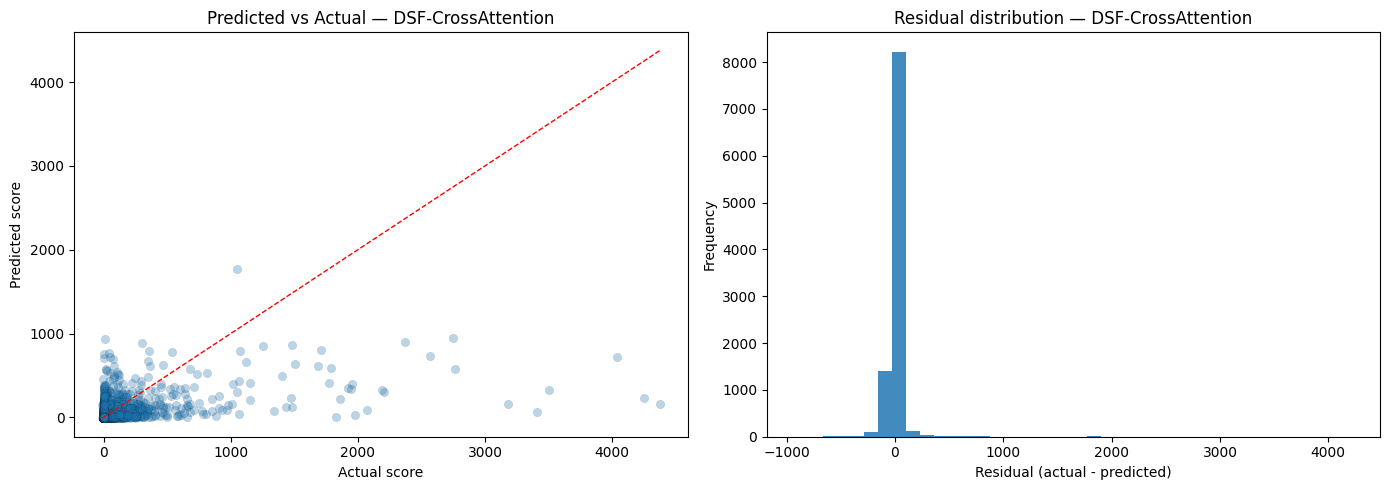

In [16]:
best_name = results_df.iloc[0]['model']
best_preds, best_targets = predictions[best_name]
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].scatter(best_targets, best_preds, alpha=0.3, edgecolor='k', linewidth=0.2)
axes[0].plot([best_targets.min(), best_targets.max()], [best_targets.min(), best_targets.max()], 'r--', linewidth=1)
axes[0].set_xlabel('Actual score')
axes[0].set_ylabel('Predicted score')
axes[0].set_title(f'Predicted vs Actual — {best_name}')

residuals = best_targets - best_preds
axes[1].hist(residuals, bins=40, color='#1f77b4', alpha=0.85)
axes[1].set_xlabel('Residual (actual - predicted)')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Residual distribution — {best_name}')
plt.tight_layout()
plt.show()

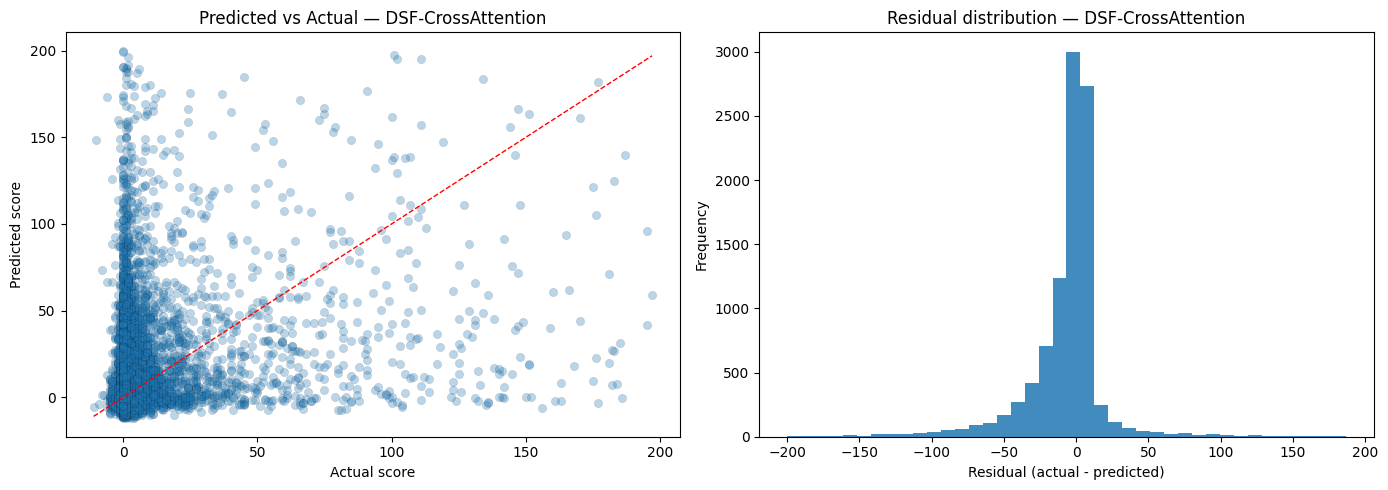

In [17]:
mask = (predictions[best_name][1] < 200) & (predictions[best_name][0] < 200)
filtered_preds, filtered_targets = predictions[best_name][0][mask], predictions[best_name][1][mask]
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].scatter(filtered_targets, filtered_preds, alpha=0.3, edgecolor='k', linewidth=0.2)
axes[0].plot([filtered_targets.min(), filtered_targets.max()], [filtered_targets.min(), filtered_targets.max()], 'r--', linewidth=1)
axes[0].set_xlabel('Actual score')
axes[0].set_ylabel('Predicted score')
axes[0].set_title(f'Predicted vs Actual — {best_name}')

residuals = filtered_targets - filtered_preds
axes[1].hist(residuals, bins=40, color='#1f77b4', alpha=0.85)
axes[1].set_xlabel('Residual (actual - predicted)')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Residual distribution — {best_name}')
plt.tight_layout()
plt.show()